In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from numpy import corrcoef, sum, log, arange
from numpy.random import rand
from matplotlib.pylab import pcolor, show, colorbar, xticks, yticks, matshow, cm, figure
from pylab import rcParams

In [2]:
stopwords = nltk.corpus.stopwords.words('dutch')
stopwords[:10]
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("dutch")

In [3]:
def tokenize_and_stem(text):
    text = text.replace("'", " ").replace(',', ' ').replace('.', ' ').replace('twitter.com', '').replace('class=', ''.replace('lockquote', ''))
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    text = text.replace("'", " ").replace(',', ' ').replace('.', ' ').replace('twitter.com', '').replace('class=', ''.replace('lockquote', ''))
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [4]:
from nagg.models import NewsItem

all_texts = NewsItem.objects.all().values_list('text', flat=True)
print(len(all_texts))

7969


In [8]:
all_texts[0]

"Protest in Wit-Rusland tegen Russische legerbasis\n\n\nZo'n duizend mensen hebben zondag in Wit-Rusland geprotesteerd tegen de plannen voor een Russische luchtmachtbasis in hun land. Volgens de betogers zou de voormalige Sovjet-republiek hiermee een 'slaaf' van het Kremlin worden.\n\n\n\nHet protest was georganiseerd door leiders van de oppositie, onder wie voormalig presidentskandidaat Nikolaj Statkevitsj, die in augustus vrij kwam na vijf jaar achter de tralies. De politie greep niet in om een einde te maken aan de betoging. De Wit-Russische president Aleksander Loekasjenko heeft tot dusver niet gereageerd op de plannen voor een Russische basis. Analisten gaan er echter vanuit dat de bouw van de basis een gelopen zaak is, aangezien Wit-Rusland afhankelijk is van Rusland voor goedkope energie. Rusland heeft al een aantal installaties in Wit-Rusland, waaronder een radarstation. Een basis ontbreekt vooralsnog.\n"

In [ ]:
tokenize_and_stem(all_texts[0])[:10]

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, max_features=200000,
                                 min_df=0.02, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,1))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)
print(tfidf_matrix.shape)

CPU times: user 1min 31s, sys: 92 ms, total: 1min 31s
Wall time: 1min 31s
(6072, 1012)


In [ ]:
terms = tfidf_vectorizer.get_feature_names()

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
dlarge = 1 - cosine_similarity(tfidf_matrix)

In [11]:
#distances = dlarge[4080:4360,4080:4360]
distances = dlarge

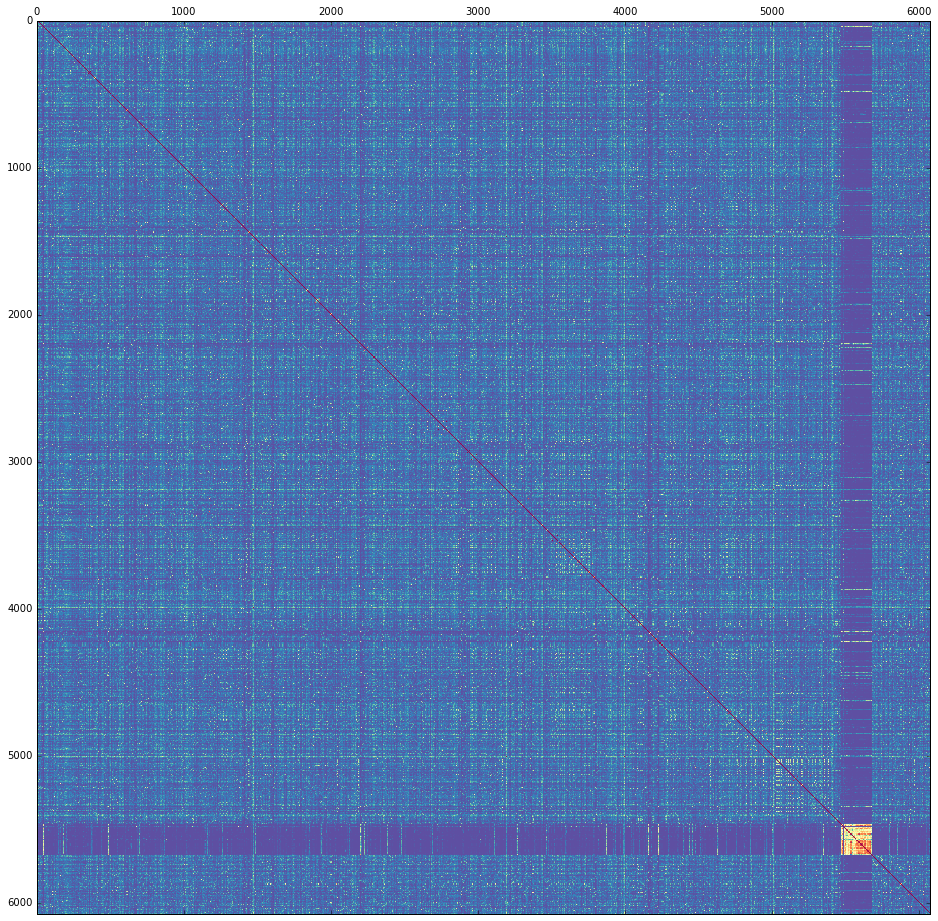

In [12]:
rcParams['figure.figsize'] = 450, 450
matshow(distances, cmap=cm.Spectral, fignum=100)

In [13]:
from sklearn.cluster import KMeans

num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 17 s, sys: 4 ms, total: 17 s
Wall time: 17 s


In [14]:
cluster_indices = sorted(range(len(clusters)), key=lambda x: clusters[x])
s1 = distances[:, cluster_indices,]
s1 = s1[cluster_indices, :]

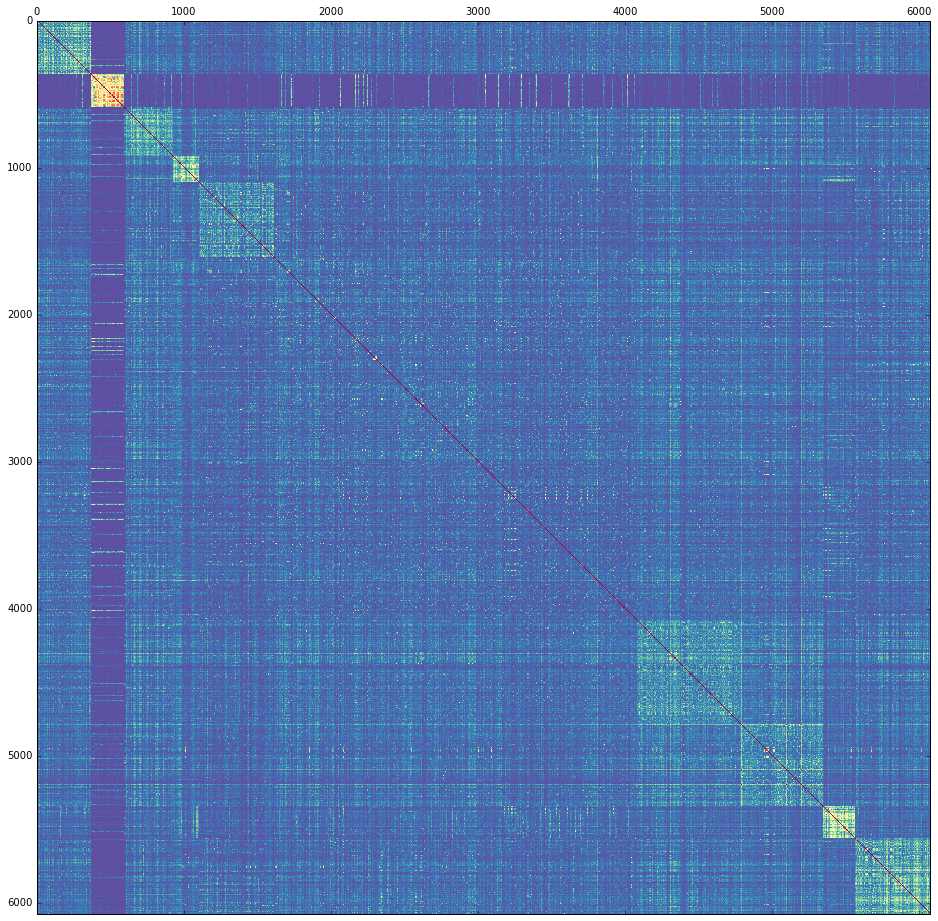

In [15]:
rcParams['figure.figsize'] = 450, 450
matshow(s1, cmap=cm.Spectral, fignum=101)

In [ ]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in all_texts:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [ ]:
print(len(totalvocab_stemmed), len(allwords_stemmed))
print(len(totalvocab_tokenized), len(allwords_tokenized))

In [ ]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

In [ ]:
vocab_frame.head()

In [ ]:
newsitems = {'text': all_texts, 'cluster': clusters}
frame = pd.DataFrame(newsitems, index=[clusters], columns=['text', 'cluster'])

In [ ]:
frame['cluster'].value_counts()

In [ ]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d text:" % i, end='')
    for title in frame.ix[i]['text'].values.tolist():
        print(' %s,' % title[:title.find('\n')], end='\n')
    print() #add whitespace
    print() #add whitespace
    print() #add whitespace
    print() #add whitespace
    print() #add whitespace
    print() #add whitespace
    print() #add whitespace
    print() #add whitespace